Name: Shivraj Ramesh Nalawade

PRN : 202301060008

# Loan Prediction — Ensemble Learning Assignment
---
### Objective:
Predict whether a loan will be approved using base models and an ensemble method.

### Models Used:
- Decision Tree
- Logistic Regression
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Stacking Ensemble (Meta-learner: Logistic Regression)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

In [2]:
# Load dataset
df = pd.read_csv('train_u6lujuX_CVtuZ9i (1).csv')
print('Shape:', df.shape)
print('Missing values:\n', df.isnull().sum())
print('\nTarget distribution:\n', df['Loan_Status'].value_counts())
df.head()

Shape: (614, 13)
Missing values:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Target distribution:
 Loan_Status
Y    422
N    192
Name: count, dtype: int64


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Preprocessing
df.drop('Loan_ID', axis=1, inplace=True)
df['Loan_Status'] = df['Loan_Status'].map({'Y':1, 'N':0})
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
df = pd.get_dummies(df, drop_first=True)
print('Encoded shape:', df.shape)
df.head()

Encoded shape: (614, 15)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
0,5849.0,0.0,128.0,360.0,1.0,1.0,True,False,False,False,False,False,False,False,True
1,4583.0,1508.0,128.0,360.0,1.0,0.0,True,True,True,False,False,False,False,False,False
2,3000.0,0.0,66.0,360.0,1.0,1.0,True,True,False,False,False,False,True,False,True
3,2583.0,2358.0,120.0,360.0,1.0,1.0,True,True,False,False,False,True,False,False,True
4,6000.0,0.0,141.0,360.0,1.0,1.0,True,False,False,False,False,False,False,False,True


In [4]:
# Train-test split and scaling
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train size:', X_train.shape[0], '| Test size:', X_test.shape[0])

Train size: 491 | Test size: 123


In [5]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=skf, scoring='accuracy')
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:,1] if hasattr(model, 'predict_proba') else None
    res = {
        'CV mean acc': round(cv_scores.mean(),4),
        'CV std': round(cv_scores.std(),4),
        'Test acc': round(accuracy_score(y_te, y_pred),4),
        'Precision': round(precision_score(y_te, y_pred, zero_division=0),4),
        'Recall': round(recall_score(y_te, y_pred, zero_division=0),4),
        'F1': round(f1_score(y_te, y_pred, zero_division=0),4),
        'ROC AUC': round(roc_auc_score(y_te, y_proba) if y_proba is not None else float('nan'),4),
        'Confusion Matrix': confusion_matrix(y_te, y_pred)
    }
    return res, model

In [6]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}
results = {}
for name, model in models.items():
    print(f'\nTraining {name}...')
    res, fitted = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    results[name] = res
    print(res)


Training Decision Tree...
{'CV mean acc': np.float64(0.6964), 'CV std': np.float64(0.0347), 'Test acc': 0.7154, 'Precision': 0.8125, 'Recall': 0.7647, 'F1': 0.7879, 'ROC AUC': np.float64(0.685), 'Confusion Matrix': array([[23, 15],
       [20, 65]])}

Training Logistic Regression...
{'CV mean acc': np.float64(0.7962), 'CV std': np.float64(0.0426), 'Test acc': 0.8618, 'Precision': 0.84, 'Recall': 0.9882, 'F1': 0.9081, 'ROC AUC': np.float64(0.8514), 'Confusion Matrix': array([[22, 16],
       [ 1, 84]])}

Training KNN...
{'CV mean acc': np.float64(0.7535), 'CV std': np.float64(0.0341), 'Test acc': 0.8374, 'Precision': 0.8283, 'Recall': 0.9647, 'F1': 0.8913, 'ROC AUC': np.float64(0.7593), 'Confusion Matrix': array([[21, 17],
       [ 3, 82]])}

Training SVM...
{'CV mean acc': np.float64(0.7922), 'CV std': np.float64(0.0419), 'Test acc': 0.8537, 'Precision': 0.8317, 'Recall': 0.9882, 'F1': 0.9032, 'ROC AUC': np.float64(0.8387), 'Confusion Matrix': array([[21, 17],
       [ 1, 84]])}


In [7]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svm', SVC(kernel='rbf', probability=True, random_state=42))
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000), cv=5)
stack_res, stack_model = evaluate_model(stack, X_train_scaled, y_train, X_test_scaled, y_test)
results['Stacking Ensemble'] = stack_res
print(stack_res)

{'CV mean acc': np.float64(0.784), 'CV std': np.float64(0.0404), 'Test acc': 0.8537, 'Precision': 0.8317, 'Recall': 0.9882, 'F1': 0.9032, 'ROC AUC': np.float64(0.8102), 'Confusion Matrix': array([[21, 17],
       [ 1, 84]])}


In [8]:
res_df = pd.DataFrame([{**{'Model':k}, **{kk:v for kk,v in v.items() if kk!='Confusion Matrix'}} for k,v in results.items()])
res_df = res_df.sort_values(by='Test acc', ascending=False).reset_index(drop=True)
res_df

,Model,CV mean acc,CV std,Test acc,Precision,Recall,F1,ROC AUC
0,Logistic Regression,0.7962,0.0426,0.8618,0.8400,0.9882,0.9081,0.8514
1,Stacking Ensemble,0.7840,0.0404,0.8537,0.8317,0.9882,0.9032,0.8102
2,SVM,0.7922,0.0419,0.8537,0.8317,0.9882,0.9032,0.8387
3,KNN,0.7535,0.0341,0.8374,0.8283,0.9647,0.8913,0.7593
4,Decision Tree,0.6964,0.0347,0.7154,0.8125,0.7647,0.7879,0.6850


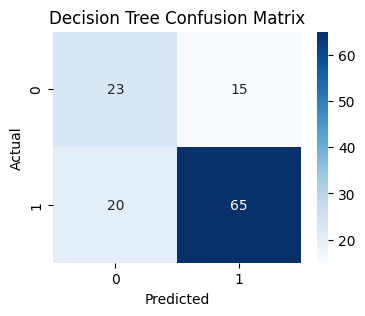

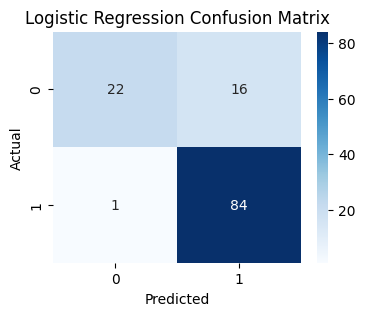

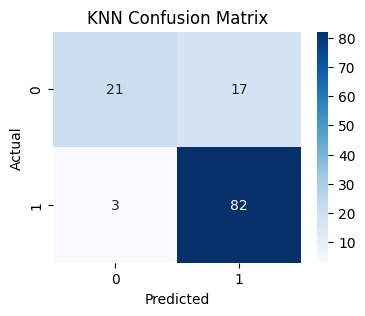

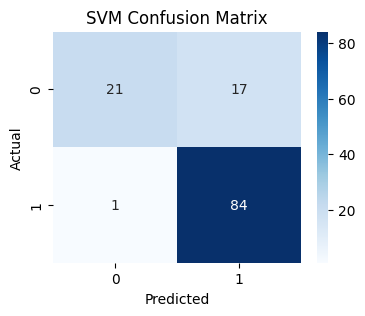

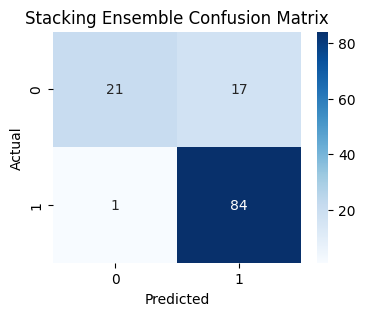

In [9]:
for name, r in results.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(r['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

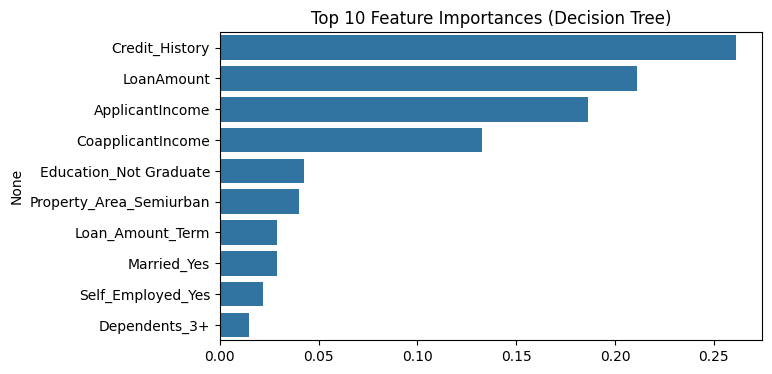

In [10]:
dt_full = DecisionTreeClassifier(random_state=42)
dt_full.fit(X_train_scaled, y_train)
importances = pd.Series(dt_full.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
plt.figure(figsize=(7,4))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.show()